# Exemplo de Classificação Binária com RNA

Este notebook demonstra o uso da implementação de Rede Neural Artificial (RNA) para um problema de classificação binária.


## 1. Importação das Bibliotecas


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import sys
import os

# Configurações de visualização
plt.style.use('ggplot')
%matplotlib inline

## 2. Importação da RNA

Para usar este notebook no Google Colab, você precisará carregar a implementação da RNA.


In [6]:
import os
try:
    import google.colab
    IN_COLAB = True
    !git clone https://github.com/pedromandelli/RNA-Implementation.git
    %cd RNA-Implementation
    sys.path.insert(0, os.path.abspath(os.getcwd()))
except:
    IN_COLAB = False
    # Adicionar o diretório src ao PYTHONPATH se estiver executando localmente
    module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    if module_path not in sys.path:
        sys.path.insert(0, module_path)


In [7]:
# Importar a implementação da RNA
from src.rna import NeuralNetwork
print("Importação da NeuralNetwork bem-sucedida.")


Importação da NeuralNetwork bem-sucedida.


## 3. Carregamento e Exploração dos Dados

Nesta seção, carregaremos um conjunto de dados para o problema de classificação binária e faremos uma exploração inicial. Usaremos o dataset de Doença Cardíaca de Cleveland, que é um problema clássico de classificação binária na área da saúde


In [8]:
if IN_COLAB:
    data_path = 'src/datasets/processed.cleveland.data'
else:
    data_path = '../../src/datasets/processed.cleveland.data'
    
colunas = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak", "slope",
    "ca", "thal", "target"
]

df = pd.read_csv(data_path, names=colunas, na_values="?")
df.dropna(inplace=True)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# Visualizar as primeiras linhas do conjunto de dados

print("Primeiras 5 linhas do conjunto de dados:")
display(df.head())

Primeiras 5 linhas do conjunto de dados:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# Informações sobre o dataset
print(f"Formato do conjunto de dados: {df.shape}")
print(f"Número de classes: {df['target'].nunique()}")
print("Distribuição das classes:")
print(df['target'].value_counts())

Formato do conjunto de dados: (297, 14)
Número de classes: 2
Distribuição das classes:
target
0    160
1    137
Name: count, dtype: int64


In [10]:
# Estatísticas descritivas
print("Estatísticas descritivas do conjunto de dados:")
display(df.describe())


Estatísticas descritivas do conjunto de dados:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


## 4. Pré-processamento dos Dados

Nesta seção, realizaremos o pré-processamento necessário para preparar os dados para o treinamento da RNA.


In [11]:
X = df.drop("target", axis=1)
y = df["target"].values.reshape(-1, 1)

colunas_numericas = ["age", "trestbps", "chol", "thalach", "oldpeak"]
colunas_categoricas = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Normalizar os dados
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), colunas_numericas),
        ("cat", OneHotEncoder(), colunas_categoricas)
    ]
)

# Aplicar o pré-processamento em todos os dados
X = preprocessor.fit_transform(X)

# Dividir os dados em treino (60%), validação (20%) e teste (20%) - seguindo a orientação do professor

# Primeiro, separar 20% para teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# Depois, separar 25% dos 80% restantes para validação (0.25 x 0.8 = 0.20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Tamanho do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Distribuição das classes em treinamento:\n{pd.Series(y_train.flatten()).value_counts()}")
print(f"Distribuição das classes em validação:\n{pd.Series(y_val.flatten()).value_counts()}")
print(f"Distribuição das classes em teste:\n{pd.Series(y_test.flatten()).value_counts()}")


Tamanho do conjunto de treinamento: (177, 28)
Tamanho do conjunto de validação: (60, 28)
Tamanho do conjunto de teste: (60, 28)
Distribuição das classes em treinamento:
0    96
1    81
Name: count, dtype: int64
Distribuição das classes em validação:
0    32
1    28
Name: count, dtype: int64
Distribuição das classes em teste:
0    32
1    28
Name: count, dtype: int64


## 5. Visualização dos Dados

Vamos visualizar algumas características dos dados para entender melhor o problema.


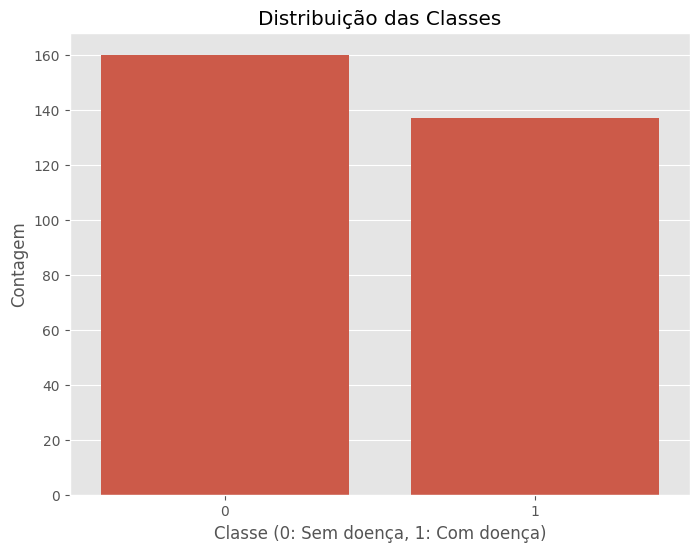

In [12]:
# Visualizar a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Distribuição das Classes')
plt.xlabel('Classe (0: Sem doença, 1: Com doença)')
plt.ylabel('Contagem')
plt.show()

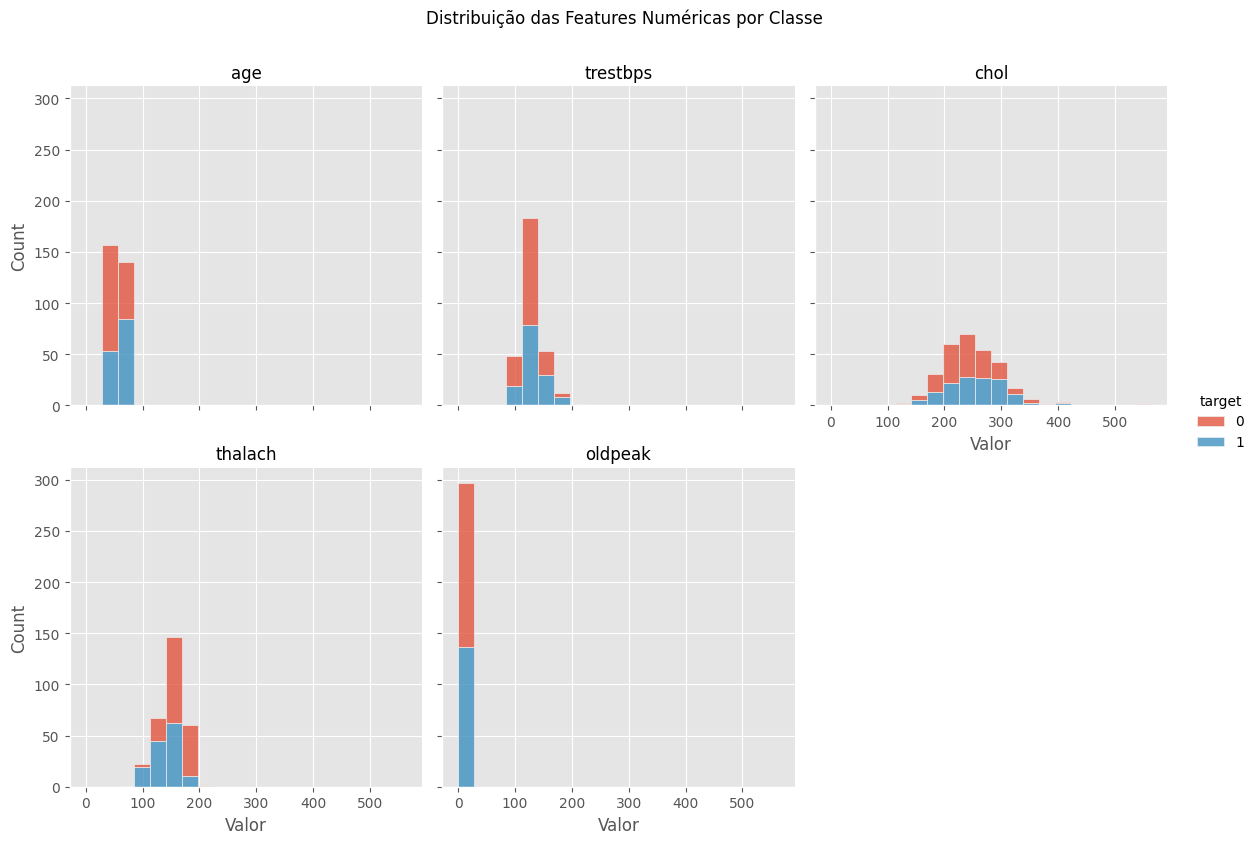

In [13]:
# Selecionar algumas features numéricas para visualização
selected_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Criar um DataFrame só com as features selecionadas + target
df_selected = df[selected_features + ['target']]

# Transformar para formato long
df_selected_melted = df_selected.melt(id_vars='target', var_name='Feature', value_name='Valor')

# Usar displot para criar vários histogramas separados por feature
g = sns.displot(
    data=df_selected_melted,
    x='Valor',
    hue='target',
    col='Feature',
    col_wrap=3,
    kind='hist',
    bins=20,
    height=4,
    multiple='stack'
)

g.set_titles("{col_name}")
g.fig.suptitle("Distribuição das Features Numéricas por Classe", y=1.05)
plt.show()


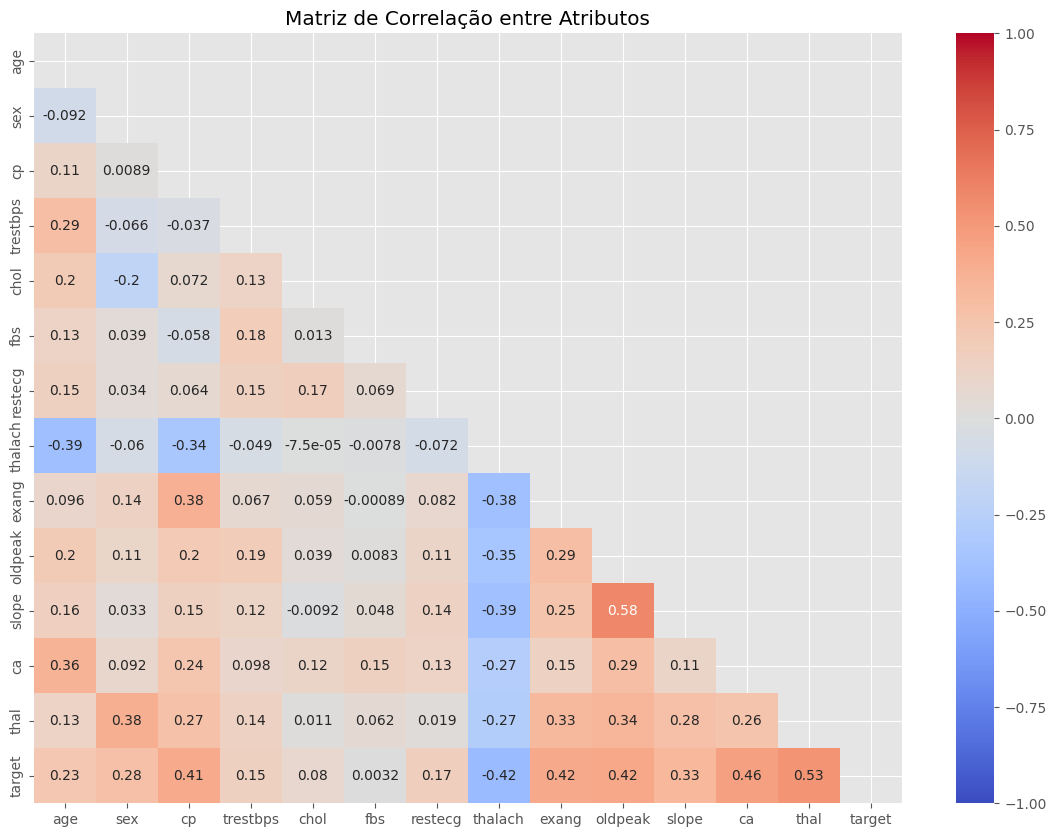

In [14]:
# Correlação
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação entre Atributos')
plt.show()

## 6. Criação e Treinamento do Modelo

Nesta seção, criaremos e treinaremos o modelo de RNA para o problema de classificação binária.


In [15]:
# Criar o modelo
model = NeuralNetwork(
    layer_sizes=[X_train.shape[1], 12, 6, 1],
    activation_functions=['relu', 'relu', 'sigmoid']
)

print("Arquitetura do modelo:")
print(model)


Arquitetura do modelo:
NeuralNetwork(layers=[28, 12, 6, 1], activation=['relu', 'relu', 'sigmoid'])


In [16]:
# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    learning_rate=0.003,
    loss_function='binary_crossentropy',
    optimizer='momentum',
    verbose=True,
    validation_data=(X_val, y_val)
)

Época 100/500 - loss: 0.6593 - val_loss: 0.6657
Época 200/500 - loss: 0.6122 - val_loss: 0.6207
Época 300/500 - loss: 0.5596 - val_loss: 0.5669
Época 400/500 - loss: 0.5136 - val_loss: 0.5231
Época 500/500 - loss: 0.4689 - val_loss: 0.4855


## 7. Avaliação do Modelo

In [17]:
# Fazer predições no conjunto de teste
y_pred_proba = model.predict(X_test, output_activation='sigmoid')

# Converter as probabilidades em classes (limiar 0.5)
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()
y_test_classes = y_test.flatten()

# Calcular a acurácia
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)
roc_auc = roc_auc_score(y_test_classes, y_pred_proba)

print(f"Acurácia no conjunto de teste: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisão: {precision:.4f}")
print(f"Revocação (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Verificar se atende ao requisito do enunciado (erro < 50% -> acurácia > 50%)
print(f"O modelo {'atende' if accuracy > 0.5 else 'não atende'} ao requisito de desempenho.")

Acurácia no conjunto de teste: 0.8667 (86.67%)
Precisão: 0.9167
Revocação (Recall): 0.7857
F1-Score: 0.8462
ROC AUC: 0.9520
O modelo atende ao requisito de desempenho.


## 8. Visualização dos Resultados


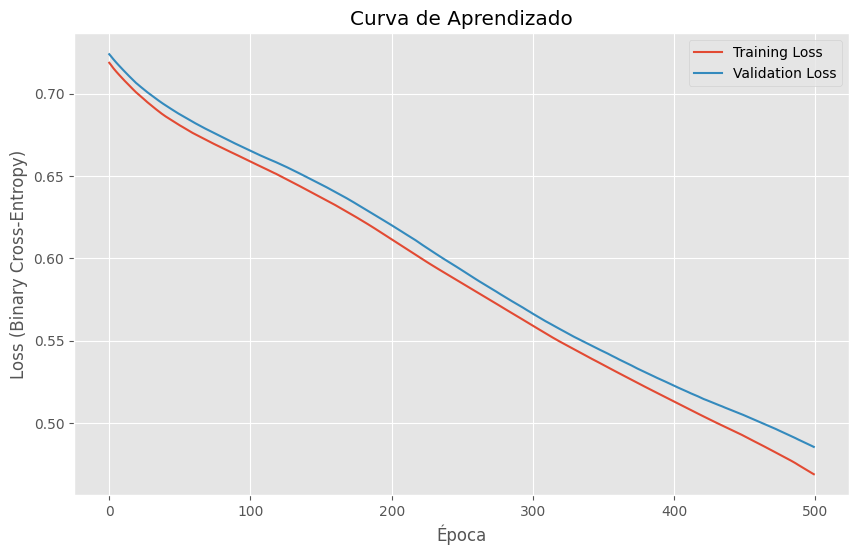

In [18]:

# Curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Época')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.legend()
plt.show()


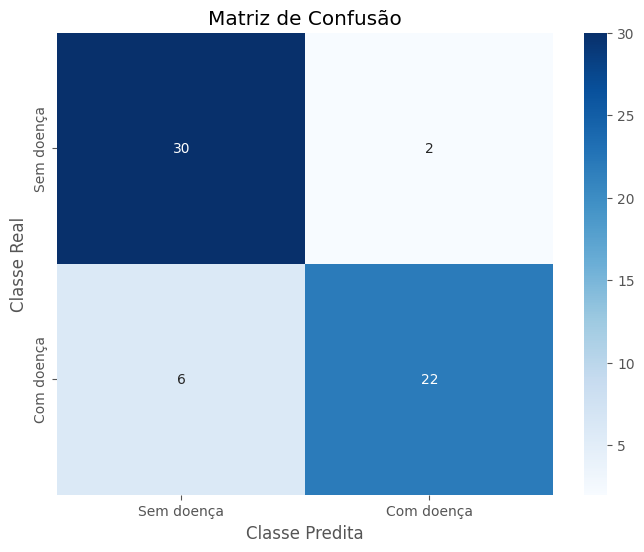

In [19]:

# Visualizar a Matriz de Confusão (gráfico)
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem doença', 'Com doença'],
            yticklabels=['Sem doença', 'Com doença'])
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

## 9. Conclusão

Neste notebook, demonstramos o uso da nossa implementação de RNA para um problema de classificação binária. Utilizando o dataset Heart Disease (Cleveland), o modelo foi capaz de aprender a identificar a presença ou ausência de doença cardíaca com desempenho satisfatório, superando a acurácia mínima exigida pelo projeto. Este experimento reforça a capacidade da rede neural implementada de resolver tarefas reais de classificação utilizando apenas bibliotecas de baixo nível.
